# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [131]:
# Imports
import json
import os.path
import time


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torchvision.models.densenet import DenseNet121_Weights

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Directories for data
data_dir = "/mnt/c/Large Files/flower_data"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [3]:
# Define transforms for the training, validation, and testing sets

# Incorporate random rotation, resized crop, and horizontal flip to keep the model generalized
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_and_validation_transforms = transforms.Compose([transforms.Resize(255),
                                                     transforms.CenterCrop(224),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                                          [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_image_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_image_dataset = datasets.ImageFolder(test_dir, transform=test_and_validation_transforms)
validation_image_dataset = datasets.ImageFolder(valid_dir, transform=test_and_validation_transforms)

# Define the dataloaders
train_data_loader = torch.utils.data.DataLoader(train_image_dataset, batch_size=64, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_image_dataset, batch_size=64, shuffle=False)
validation_data_loader = torch.utils.data.DataLoader(validation_image_dataset, batch_size=64, shuffle=False)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [35]:
# create a class_label_to_class_name helper dictionary
def build_class_label_to_class_name_mapping(cat_to_name, class_to_idx):
    """
    Args:
        cat_to_name[class_label_str] = class_name
            Ex: {"1" : "pink primrose", "2" : "hard-leaved pocket orchid", ..}
        class_to_idx[class_label_str] = class_label_int
            Ex: {"1" : 0, "2" : 1, ..}
    Return:
        class_label_to_class_name[class_label_int] = class_name
            Ex: {0 : "pink primrose", 1 : "hard-leaved pocket orchid", ..}
    """
    class_label_to_class_name = dict()
    for class_label_str, class_label in class_to_idx.items():
        class_name = cat_to_name[class_label_str]
        # protect against a repeated class label (which should never happen)
        if class_label in class_label_to_class_name:
            raise ValueError(f"repeated class label ({class_label})")
        class_label_to_class_name[class_label] = class_name

    return class_label_to_class_name

class_label_to_class_name = build_class_label_to_class_name_mapping(cat_to_name, train_image_dataset.class_to_idx)

# #   
# #   cat_to_n
# class_label_to_class_name = dict()
# for key, value in cat_to_name.items():
#     new_key = int(key)
#     if new_key in class_label_to_class_name:
#         raise ValueError(f"new_key ({new_key}) is already in dictionary!  Are there keys with a leading zero in 'cat_to_name.json' (e.g. keys of '01' and '1')")
#     class_label_to_class_name[new_key] = value
# train_image_dataset.class_to_idx

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [10]:
# define helper function 

def get_test_stats(model, criterion, loader, device=torch.device("cuda:0")):
    running_loss = 0.0
    num_correct = 0
    num_total = 0
    model.eval()
    for inputs, labels in loader:
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device=device), labels.to(device=device)

        # forward propagate (no gradient tracking)
        with torch.no_grad():
            logps = model.forward(inputs)

        # calculate loss and add to running total
        loss = criterion(logps, labels)
        running_loss += loss.item()

        # determine accuracy and add to running totals
        torch.topk(logps, 1, dim=1).values
        num_correct += (torch.topk(logps, 1, dim=1).indices == labels.view(-1,1)).sum().item()
        num_total += len(labels)
    model.train()
    loss = running_loss / len(loader)
    accuracy = num_correct / num_total

    return loss, accuracy

In [11]:
# load pretrained densenet121 model
#model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model = models.densenet121(pretrained=True)

# freeze densenet parameters (so that we don't do backpropagation through them)
for param in model.parameters():
    param.requires_grad = False

# define new classifier
num_classes = 102
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
#                                 nn.Dropout(0.2),
                                 nn.Linear(512, num_classes),
                                 nn.LogSoftmax(dim=1))

# from collections import OrderedDict
# classifier = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(1024, 500)),
#                           ('relu', nn.ReLU()),
#                           ('fc2', nn.Linear(500, 102)),
#                           ('output', nn.LogSoftmax(dim=1))
#                           ]))

# model.classifier = classifier    

# Use Negative Log Likelihood loss criterion
criterion = nn.NLLLoss()

# Use Adam for optimization
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

/home/mperkett/.pyenv/versions/3.11.7/envs/udacity-pandas/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mperkett/.pyenv/versions/3.11.7/envs/udacity-pandas/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
torch.cuda.is_available()

True

In [14]:
%pdb 0

# user parameters
num_epochs = 1
device = torch.device("cuda:0")

# move model tensors to device
model.to(device=device)

start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_start_time = time.time()
    for batch_num, (inputs, labels) in enumerate(train_data_loader):
        # print batch number periodically to show progress
        if (batch_num > 0 and (batch_num + 1) % 30 == 0) or batch_num == len(train_data_loader) - 1:
            print(f"\tbatch_num: {batch_num + 1} / {len(train_data_loader)}")
        
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device=device), labels.to(device=device)

        # forward propagate and calculate loss
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        # backpropagate and take optimization step
        # gradients are zerod before backpropagation since they accumulate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # keep running total of loss
        running_loss += loss.item()

    # print information on model training and performance on test data
    train_loss = running_loss / len(train_data_loader)
    validation_loss, validation_accuracy = get_test_stats(model, criterion, validation_data_loader, device=device)
    epoch_run_time = time.time() - epoch_start_time
    print(f"epoch: {epoch} | run_time: {epoch_run_time:.1f} | training loss: {train_loss} | testing loss: {validation_loss} | testing accuracy: {validation_accuracy}")

run_time = time.time() - start_time

print(f"run_time: {run_time}")

Automatic pdb calling has been turned OFF
	batch_num: 50 / 103
	batch_num: 100 / 103
	batch_num: 103 / 103
epoch: 0 | run_time: 92.3 | training loss: 2.927250619073516 | testing loss: 1.219450322481302 | testing accuracy: 0.7298288508557457
run_time: 92.27313232421875


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

See [Saving & Loading a General Checkpoint for Inference and/or Resuming Training](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training) for more information

In [15]:
# Calculate accuracy on training, validation, and testing data
# Run times
#   testing: 1:54

#train_loss, train_accuracy = get_test_stats(model, criterion, train_data_loader, device=device)
#print(f"Training accuracy: {train_accuracy}")
#validation_loss, validation_accuracy = get_test_stats(model, criterion, validation_data_loader, device=device)
#print(f"Validation accuracy: {validation_accuracy}")

test_loss, test_accuracy = get_test_stats(model, criterion, test_data_loader, device=device)
print(f"Testing accuracy: {test_accuracy}")


Testing accuracy: 0.7008547008547008


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [38]:
def save_checkpoint(model, output_file_path):
    """
    Save model to checkpoint file with enough information to restore for inference or to
    continue training.
    
    This function relies on the base model being known with only the model.classifier member
    having been modified with a NN specified using nn.Sequential.  It is sufficient to use the
    repr for each module that is part of module.classifier to store.  NOTE:  this has held
    in limited testing, but needs broader testing to see if it holds more generally.  The
    conversion is tested before save and an error is be thrown if the repr string is not
    sufficient to create an identical object (tested using module object's __eq__ method
    """
    # TODO: try with other ImageNet models and see what needs to be modified
    # Example list:
    #       [torch.nn.Linear(in_features=1024, out_features=512, bias=True),
    #        torch.nn.ReLU(),
    #        torch.nn.Linear(in_features=512, out_features=102, bias=True),
    #        torch.nn.LogSoftmax(dim=1)]

    # throw an error if model.classifier isn't of the type expected
    if type(model.classifier) != torch.nn.modules.container.Sequential:
        raise ValueError("save_checkpoint() only works for models with model.classifier replaced with a nn.Sequential(..) definition.")
    
    # build list of repr for each module
    classifier_module_reprs = [f"torch.nn.{repr(module)}" for module in model.classifier]
    
    # verify that reprs restore objects as expected
    # for module_repr, module_object in zip(classifier_module_reprs, model.classifier):
    #     if eval(module_repr) != module_object:
    #         raise AssertionError("repr for ({module_repr}) was not sufficient to restore an identical module")
    
    # save classifier info and model's state_dict to file
    checkpoint = {"classifier_module_reprs" : classifier_module_reprs,
                  "state_dict": model.state_dict(),
                  "class_label_to_class_name" : class_label_to_class_name}
    torch.save(checkpoint, output_file_path)

    return

In [39]:
#print(type(model.classifier)) 
#print(type(torch.nn.modules.container.Sequential))
save_checkpoint(model, "checkpoint.pt")

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [40]:
def load_checkpoint(checkpoint_file_path):
    """
    Load saved model from checkpoint file.
    """
    # read checkpoint file into dictionary
    checkpoint_dict = torch.load(checkpoint_file_path)

    # load pretrained densenet121 model
    #model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    model = models.densenet121(pretrained=True)

    # define a new classifier using the saved repr string to build up a list of objects
    classifier_modules = [eval(repr_str) for repr_str in checkpoint_dict["classifier_module_reprs"]]
    model.classifier = nn.Sequential(*classifier_modules)

    # load all tensors into model
    model.load_state_dict(checkpoint_dict["state_dict"])

    class_label_to_class_name = checkpoint_dict["class_label_to_class_name"]

    return model, class_label_to_class_name

In [53]:
# Test loading saved model
loaded_model, loaded_class_label_to_class_name = load_checkpoint("checkpoint.pt")
loaded_model.to(device="cuda:0")

# display some info to see loaded model
print(model)
print("loaded_class_label_to_class_name")
for n, (key, val) in enumerate(loaded_class_label_to_class_name.items()):
    if n == 5:
        break
    print(f"{str(key).ljust(5)}{val}")

/home/mperkett/.pyenv/versions/3.11.7/envs/udacity-pandas/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mperkett/.pyenv/versions/3.11.7/envs/udacity-pandas/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [20]:
# functions for image processing
def process_image(image_file_path):
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model,
    returns an Numpy array

    Args:
        image_file_path: file path for image to be processed
    Return:
        torch tensor of processed
    """
    with Image.open(image_file_path) as image:
        image = image.resize((255, 255))
        image = center_crop(image, 224, 224)

    # convert to a numpy array: shape = (height, width, num_channels)
    im_arr = np.array(image)

    # normalize as expected by imagenet
    norm_im_arr = normalize_for_imagenet(im_arr)

    # transpose to shape = (num_channels, height, width)
    reshaped_norm_im_arr = np.transpose(norm_im_arr, axes=(2,0,1))

    return torch.tensor(reshaped_norm_im_arr, dtype=torch.float)


def center_crop(image, width, height):
    """
    Crop image to a centered box with dimensions (width, height)

    Args:
        image: PIL Image to crop
        width: integer number of pixels width for cropped image
        height: integer number of pixels height for cropped image
    
    Return:
        cropped_image: cropped PIL Image
    """
    im_width, im_height = image.size
    if im_width < width or im_height < height:
        raise ValueError(f"requested cropped image size ({width}, {height}) is larger than the image ({im_width}, {im_height})")

    # determine left and right indices for crop    
    width_buffer = (im_width - width)
    left = width_buffer / 2
    right = left + width

    # determine upper and lower indices for crop    
    height_buffer = (im_height - height)
    upper = height_buffer / 2
    lower = upper + height

    # crop image
    cropped_image = image.crop((left, upper, right, lower))

    # verify that cropped image is as expected
    cropped_width, cropped_height = cropped_image.size
    if cropped_width != width or cropped_height != height:
        raise AssertionError(f"Cropped image ({cropped_width}, {cropped_height}) is not of the expected dimensions ({width}, {height})")

    return cropped_image


def normalize_for_imagenet(im_arr):
    """
    Perform standard normalization by channel expected by ImageNet
        norm = (scaled_im_arr - mean) / stdev
    
    Args:
        im_arr: numpy array with shape = (height, width, num_channels)
    
    Return:
        norm_im_array: normalized im_arr with shape = (height, width, num_channels)
    """
    # scale values in range of [0, 1] (im_arr values are in range [0, 255])
    scaled_im_arr = im_arr / 255.0

    # normalize
    imagenet_means = np.array([0.485, 0.456, 0.406])
    imagenet_stdevs = np.array([0.229, 0.224, 0.225])
    norm_im_arr = (scaled_im_arr - imagenet_means) / imagenet_stdevs

    return norm_im_arr

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [21]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

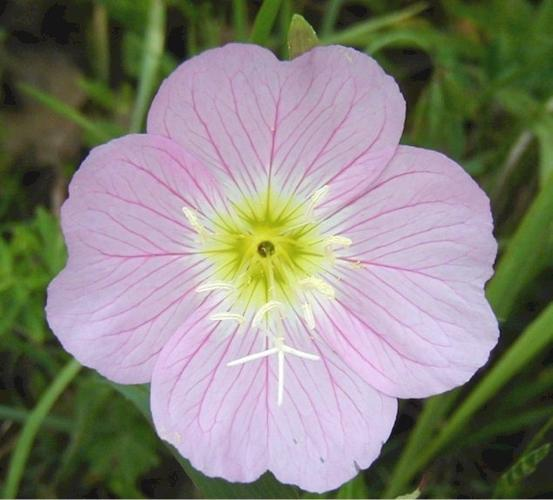

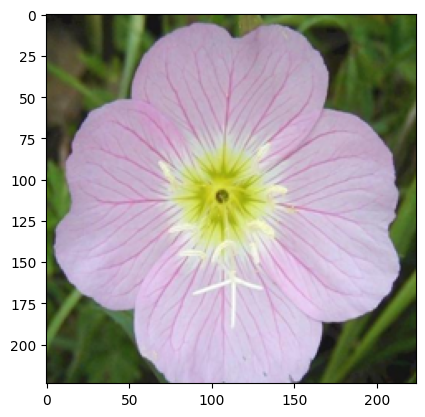

In [75]:
# Verify that processing image functions work on an example image
image_file_path = os.path.join(train_dir, "1/image_06742.jpg")

# display original unprocessed image
with Image.open(image_file_path) as orig_image:
    display(orig_image)

# display processed image from tensor output (expect to see a 
# resized, center-cropped version of the original image)
im_tensor = process_image(image_file_path)
ax = imshow(im_tensor)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [77]:
def predict(image_file_path, model, topk=5, device=torch.device("cuda:0")):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    """
    model_was_in_training_state = model.training
    model.eval()
    
    # reshape the 3 dim single image tensor provided by process_image to the expected
    # 4 dim tensor.  And move it to device.
    im_tensor = process_image(image_file_path)
    im_tensor = im_tensor.view(1, *im_tensor.shape)
    im_tensor = im_tensor.to(device)
    
    with torch.no_grad():
        logps = model.forward(im_tensor)
        probabilities = torch.exp(logps)
    
    topk_tensor = torch.topk(probabilities, topk, dim=1)
    predicted_topk_class_probs = topk_tensor.values.flatten().cpu().numpy()
    predicted_topk_class_labels = topk_tensor.indices.flatten().cpu().numpy()
    

    if model_was_in_training_state:
        model.train()
    
    return predicted_topk_class_labels, predicted_topk_class_probs

In [78]:
# Example of using this method
image_file_path = os.path.join(train_dir, "1/image_06742.jpg")
predicted_topk_class_labels, predicted_topk_class_probs = predict(image_file_path, model, topk=10)

print("label   prob    name")
for class_label, class_prob in zip(predicted_topk_class_labels, predicted_topk_class_probs):
    class_name = class_label_to_class_name[class_label]
    print(f"{str(class_label).ljust(8)}{class_prob:.4f}  {class_name}")

label   prob    name
0       0.1713  pink primrose
76      0.1218  morning glory
30      0.0590  mexican aster
61      0.0553  japanese anemone
87      0.0534  tree mallow
50      0.0489  wild pansy
64      0.0458  californian poppy
13      0.0410  balloon flower
90      0.0332  watercress
49      0.0261  petunia


In [79]:
# Verify that we get the same prediction with the loaded model
predicted_topk_class_labels_loaded, predicted_topk_class_probs_loaded = predict(image_file_path, loaded_model, topk=10)
if (predicted_topk_class_probs_loaded == predicted_topk_class_probs).all() \
        and (predicted_topk_class_labels_loaded == predicted_topk_class_labels).all() \
        and loaded_class_label_to_class_name == class_label_to_class_name:
    print("Loaded model predictions match model predictions!")
else:
    raise AssertionError("Loaded model predictions do not match!")

print("label   prob    name")
for class_label, class_prob in zip(predicted_topk_class_labels_loaded, predicted_topk_class_probs_loaded):
    class_name = loaded_class_label_to_class_name[class_label]
    print(f"{str(class_label).ljust(8)}{class_prob:.4f}  {class_name}")

Loaded model predictions match model predictions!
label   prob    name
0       0.1713  pink primrose
76      0.1218  morning glory
30      0.0590  mexican aster
61      0.0553  japanese anemone
87      0.0534  tree mallow
50      0.0489  wild pansy
64      0.0458  californian poppy
13      0.0410  balloon flower
90      0.0332  watercress
49      0.0261  petunia


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# # work it out manually
# # Choose the same image as given in the example above
# image_file_path = os.path.join(test_dir, "28/image_05230.jpg")
# #image_file_path = os.path.join(test_dir, "28/image_05242.jpg")

# predicted_topk_class_labels, predicted_topk_class_probs = predict(image_file_path, model, topk=5)
# class_names = [class_label_to_class_name[class_label] for class_label in predicted_topk_class_labels]


# # create subplots with two axes and 1 column.  Adjust "height space ("hspace") to be zero
# # to keep flower image close to the bar plot below it.
# # reference: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
# _, ax = plt.subplots(nrows=2, ncols=1, figsize=(4.5,10))
# plt.subplots_adjust(hspace=0.0)

# # display processed flower image
# im_tensor = process_image(image_file_path)
# _ = imshow(im_tensor, ax=ax[0])

# # Remove ticks and labels
# # modified from https://stackoverflow.com/questions/12998430/how-to-remove-xticks-from-a-plot
# ax[0].tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

# # plot top 5 predicted class probabilities
# _ = sns.barplot(x=predicted_topk_class_probs, y=class_names, ax=ax[1])

# # Anchor axes to align images
# # reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_anchor.html
# ax[0].set_anchor("W")
# ax[1].set_anchor("W")

In [154]:
def plot_predictions(image_file_path, predicted_topk_class_labels, predicted_topk_class_probs, 
                        class_label_to_class_name, topk=5):
    """
    Process provided image and display it above the predicted class probability for the topk
    most likely classes.
    """
    if topk > len(predicted_topk_class_labels):
        raise ValueError(f"Predictions were provided for the top {len(predicted_topk_class_labels)} classes, but {topk} were requested")

    class_names = [class_label_to_class_name[class_label] for class_label in predicted_topk_class_labels]


    # create subplots with two axes and 1 column.  Adjust "height space ("hspace") to be zero
    # to keep flower image close to the bar plot below it.
    # reference: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
    _, ax = plt.subplots(nrows=2, ncols=1, figsize=(4.8,10))
    plt.subplots_adjust(hspace=0.0)

    # display processed flower image
    im_tensor = process_image(image_file_path)
    _ = imshow(im_tensor, ax=ax[0])

    # Remove ticks and labels
    # modified from https://stackoverflow.com/questions/12998430/how-to-remove-xticks-from-a-plot
    ax[0].tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

    # plot top 5 predicted class probabilities
    _ = sns.barplot(x=predicted_topk_class_probs[:topk], y=class_names[:topk], ax=ax[1])

    # Anchor axes to align images
    # reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_anchor.html
    ax[0].set_anchor("W")
    ax[1].set_anchor("W")

    return ax

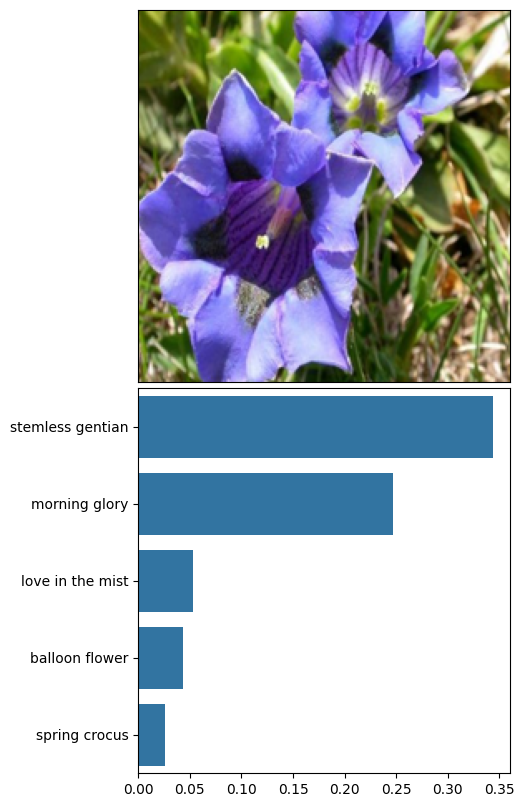

In [153]:
# Example using the same test image as displayed in instructions
image_file_path = os.path.join(test_dir, "28/image_05230.jpg")
predicted_topk_class_labels, predicted_topk_class_probs = predict(image_file_path, model, topk=10)
ax = plot_predictions(image_file_path, predicted_topk_class_labels, \
                        predicted_topk_class_probs, class_label_to_class_name, topk=5)